# Задание

### Сводная информация о количестве своевременных, задержанных, отмененных и измененных рейсов в США за 2015 год

https://www.kaggle.com/usdot/flight-delays

1. Найти аэропорт с минимальной задержкой вылета 
2. Определить самую пунктуальную авиакомпанию на прилёт в Los Angeles International Airport
3. Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)
4. Построить модель, которая будет выбирать топ-3 аэропорта прилёта (вероятность опоздания минимальная - RMSE метрика) в зависимости от аэропорта вылета  

# Описание данных

**airlines**
* `IATA_CODE` - код авиакомпании
* `AIRLINE` - название авиакомпании


**airports**
* `IATA_CODE` - код аэропорта
* `AIRPORT` - название аэропорта
* `CITY` - город
* `STATE`	- штат
* `COUNTRY` - страна
* `LATITUDE` - координаты аэропорта: широта
* `LONGITUDE` - координаты аэропорта: долгота


**flights**
* `YEAR` - год полета 
* `MONTH` - месяц полета                   
* `DAY` - день полета                     
* `DAY_OF_WEEK` - день недели полета             
* `AIRLINE` - код авиакомпании               
* `FLIGHT_NUMBER` - номер рейса      
* `TAIL_NUMBER` - номер воздушного судна
* `ORIGIN_AIRPORT` - аэропорт отправления
* `DESTINATION_AIRPORT` - аэропорт назначения
* `SCHEDULED_DEPARTURE` - запланированное время отправления  
* `DEPARTURE_TIME` (WHEEL_OFF - TAXI_OUT) - время отправления (разница времени wheels_off и taxi_out)
* `DEPARTURE_DELAY` - задержка вылета (может быть отрицательной)
* `TAXI_OUT` - время руления (продолжительность времени, прошедшего между выездом из ворот аэропорта отправления и wheels_off)
* `WHEELS_OFF` - момент времени, когда колёса самолета отрываются от земли
* `SCHEDULED_TIME` - запланированное количество времени, необходимое для перелёта
* `ELAPSED_TIME` (AIR_TIME+TAXI_IN+TAXI_OUT) - общее истекшее время (время полёта + время руления в аэропорту отправления и прибытия)
* `AIR_TIME` - продолжительность времени между wheels_off и wheels_on 
* `DISTANCE` - расстояние между двумя аэропортами
* `WHEELS_ON` - момент времени, когда колёса самолета касаются земли
* `TAXI_IN` - время руления (продолжительность времени, прошедшего между wheels_on и прибытием на посадку в аэропорту назначения)
* `SCHEDULED_ARRIVAL` - планируемое время прибытия
* `ARRIVAL_TIME` (WHEELS_ON+TAXI_IN) - время прибытия (сумма времени wheels_on и taxi_in)
* `ARRIVAL_DELAY` (ARRIVAL_TIME-SCHEDULED_ARRIVAL) - задержка прибытия (разница времени arrival_time и scheduled_arrival)
* `DIVERTED` - отклонение (самолет приземлился в аэропорту, отличном от запланированного)
* `CANCELLED` - рейс отменен (1 = отменен)  
* `CANCELLATION_REASON` - причина отмены рейса: A - Авиакомпания/Перевозчик; B - Погода; C - Национальная воздушная система; D - Безопасность 
* `AIR_SYSTEM_DELAY` - задержка, вызванная воздушной системой
* `SECURITY_DELAY` - задержка, вызванная безопасностью
* `AIRLINE_DELAY` - задержка, вызванная авиакомпанией
* `LATE_AIRCRAFT_DELAY` - задержка, вызванная самолётом
* `WEATHER_DELAY` - задержка, вызванная погодными условиями 

### План:
1. [Загрузим данные и проведём исследовательский анализ данных (EDA)](#researchdata)  
    - [Посмотрим на датасеты: какая информация в них содержится, есть ли отсутствующие данные, соответствуют ли типы данных самим данным](#describe)
    - [Обработаем данные для дальнейшей работы с ними](#processing)
    
    
2. [Найдём аэропорт с минимальной задержкой вылета](#airportmindepdelay)  
    - [Вычислим среднюю задержку вылета в каждом аэропорту](#meanndepdelay)   
    - [Узнаем аэропорт, где значение задержки вылета минимально](#mindepdelay)       


3. [Найдём cамую пунктуальную авиакомпанию на прилёт в Los Angeles International Airport](#laairlinepunctual)  
    - [Узнаем код аэропорта и названия авиакомпаний, которые в него прилетают](#laairline)   
    - [Найдём, какая компания прибывает в LA с минимальной задержкой](#minarrivaldelay)   
    

4. [Найдём аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)](#airportmintaxi)  
    - [Узнаем, сколько времени самолёты проводят на рулении в каждом аэропорту](#taxi)  
    - [Найдём среднее время руления в каждом аэропорту и определим аэропорты с максимальным временем руления](#meantaxi)  


5. [Построим модель, которая будет выбирать топ-3 аэропорта прилёта в зависимости от аэропорта вылета (вероятность опоздания минимальная - RMSE метрика)](#model)
    - [Напишем функцию для генерации фич-признаков для модели](#make_features)
    - [Обучим модель линейной регрессии на временных рядах](#fitmodel)
    - [На основании RMSE метрики модели выберем топ-3 аэропорта прилёта для каждого аэропорта вылета](#top3destairport)
    
    
6. [Сформулируем общие выводы](#conclusion)    

<a name="researchdata"></a>

## 1. Загрузим и изучим данные

**Импортируем библиотеки**

In [2]:
import pandas as pd
import numpy as np
import datetime
from math import sqrt

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

<a name="describe"></a>

**Загружаем файлы с данными**

Данные об авиакомпаниях

In [3]:
airlines = pd.read_csv('airlines.csv')

airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


Данные об аэропортах

In [4]:
airports = pd.read_csv('airports.csv')

airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


Данные о полётах

In [5]:
flights = pd.read_csv('flights.csv')

flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


**Посмотрим на общую информацию по датасетам, изучим данные**

Первые две таблицы с авиакомпаниями и аэропортами небольшие, посмотрим сначала сводную информацию по ним

In [6]:
airlines_airports = [airlines, airports]

for a in airlines_airports:
    print('Total info: ', a.columns[1])
    print()
    print('Shape: ', a.shape)
    print('Duplicate count: ', a.duplicated().sum())
    print()
    print(a.info())
    print()
    print()

Total info:  AIRLINE

Shape:  (14, 2)
Duplicate count:  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes
None


Total info:  AIRPORT

Shape:  (322, 7)
Duplicate count:  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB
None




*Выводы:*
* Типы данных соответствуют данным в столбцах таблиц.
* Дубликатов нет ни в одной из таблиц, данные по авиакомпаниях и аэропортам уникальны.
* В таблице с авикомпаниями нет пропусков, в таблице с аэропортами у трёх аэропортов не указаны координаты (широта и долгота).

*Предобработка данных в таблицах с авиакомпаниями и аэропортами не требуется.*

Таблица с полётами содержит много данных, исследуем её. Для удобства соберём информацию о типах данных, кол-ве данных и пропусках (кол-во и доля) в одну таблицу

In [7]:
flights_info = pd.DataFrame(flights.dtypes).rename(columns={0:'column_type'})
flights_info['is_not_null'] = pd.DataFrame(flights.count())
flights_info['is_null'] = pd.DataFrame(flights.isnull().sum())
flights_info['is_null (%)'] = pd.DataFrame(flights.isnull().sum()/flights.shape[0]*100).round(2)

flights_info

,column_type,is_not_null,is_null,is_null (%)
YEAR,int64,5819079,0,0.00
MONTH,int64,5819079,0,0.00
DAY,int64,5819079,0,0.00
DAY_OF_WEEK,int64,5819079,0,0.00
AIRLINE,object,5819079,0,0.00
FLIGHT_NUMBER,int64,5819079,0,0.00
TAIL_NUMBER,object,5804358,14721,0.25
ORIGIN_AIRPORT,object,5819079,0,0.00
DESTINATION_AIRPORT,object,5819079,0,0.00
SCHEDULED_DEPARTURE,int64,5819079,0,0.00


Также дополнительно проверим, сколько авиакомпаний и аэропортов в таблице flights, чтобы знать, полные ли у нас данные. Мы знаем из таблицы airlines о 14 авиакомпаниях, а из airports - о 322 аэропортах.

In [8]:
print('Кол-во авиакомпаний в таблице flights: ', flights['AIRLINE'].nunique())
print('Кол-во аэропортов отправления в таблице flights: ', flights['ORIGIN_AIRPORT'].nunique())
print('Кол-во аэропортов назначения в таблице flights: ', flights['DESTINATION_AIRPORT'].nunique())

Кол-во авиакомпаний в таблице flights:  14
Кол-во аэропортов отправления в таблице flights:  930
Кол-во аэропортов назначения в таблице flights:  930


*Выводы:*
* Не все типы данных соответствуют данным в столбцах таблиц:
    - Даты рейсов `YEAR`, `MONTH`, `DAY` (год, месяц, день) указаны в данных в виде чисел с типом int. Стоит объединить эти данные в единый параметр "Дата", если в будущем будем работать с датами.
    - Время `SCHEDULED_DEPARTURE`, `DEPARTURE_TIME`, `WHEELS_OFF`, `WHEELS_ON`, `SCHEDULED_ARRIVAL`, `ARRIVAL_TIME` (например, 00:05 или 23:54) определилось как числовой параметр int или float (5 или 2354), необходимо привести данные в соответствие. 
    - Время задержки рейсов `DEPARTURE_DELAY`, `ARRIVAL_DELAY`, время руления и перелётов `TAXI_OUT`, `TAXI_IN`, `AIR_TIME`, `SCHEDULED_TIME`, `ELAPSED_TIME` исчисляются в минутах, в датасете тип данных определился float - нам это не будет мешать, менять тип данных не будем.
    
    
* Больше всего пропусков в данных:
    - О причинах отмены рейсов `CANCELLATION_REASON` - ожидаемо, т.к. доля отменных рейсов достаточно мала в сравнении с общим кол-вом рейсов.
    - О задержках по определённым причинам `AIR_SYSTEM/SECURITY/AIRLINE/LATE_AIRCRAFT/WEATHER_DELAY` - также ожидаемо, т.к. указанные причины задержки есть далеко не у всех рейсов. 
    
    В остальных данных пропусков либо нет, либо они составляют не более 2%.
    
    
* В таблице с полётами определилось 930 уникальных аэропортов (в таблице с аэропортами их 322) - необходимо разобраться в причинах трёхкратного превышения данных об аэропортах.    

<a name="processing"></a>

**Предобработаем данные**

Работать будем с таблицей с полётами flights, т.к. в двух других таблицах обработка данных не требуется, как мы выяснили ранее.

Сначала разберёмся с типами данных, затем с пропусками и дублированием данных об аэропортах.

*Типы данных*

* Создадим поле с датой рейсов, для этого объединим поля с указанием года, месяца и дня полёта

In [9]:
flights['DATE'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY']])

flights[['YEAR', 'MONTH', 'DAY', 'DATE']].head()

,YEAR,MONTH,DAY,DATE
0,2015,1,1,2015-01-01
1,2015,1,1,2015-01-01
2,2015,1,1,2015-01-01
3,2015,1,1,2015-01-01
4,2015,1,1,2015-01-01


* Напишем функцию, которая преобразует время, определившееся как числовой параметр float, в формат времени: HH:MM:SS (часы:минуты:секунды) (за код [спасибо kaggle](https://www.kaggle.com/code/fabiendaniel/predicting-flight-delays-tutorial))

In [10]:
def conv_time(time_val):
    if pd.isnull(time_val):
        return np.nan
    else:
            # заменим время 24:00 на более привычное 00:00:
        if time_val == 2400: 
            time_val = 0
            
            # зададим параметр времени в виде 4-хзначного значения
        time_val = "{0:04d}".format(int(time_val))
        
            # переведём полученное значение в формат времени
        time_formatted = datetime.time(int(time_val[0:2]), int(time_val[2:4]))
        
    return time_formatted

Применим функцию к выбранным столбцам

In [11]:
flights['SCHEDULED_DEPARTURE'] = flights['SCHEDULED_DEPARTURE'].apply(conv_time)
flights['DEPARTURE_TIME'] = flights['DEPARTURE_TIME'].apply(conv_time)
flights['WHEELS_OFF'] = flights['WHEELS_OFF'].apply(conv_time)
flights['WHEELS_ON'] = flights['WHEELS_ON'].apply(conv_time)
flights['SCHEDULED_ARRIVAL'] = flights['SCHEDULED_ARRIVAL'].apply(conv_time)
flights['ARRIVAL_TIME'] = flights['ARRIVAL_TIME'].apply(conv_time)

In [12]:
flights[['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'WHEELS_OFF', 'WHEELS_ON', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']].head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,WHEELS_OFF,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVAL_TIME
0,00:05:00,23:54:00,00:15:00,04:04:00,04:30:00,04:08:00
1,00:10:00,00:02:00,00:14:00,07:37:00,07:50:00,07:41:00
2,00:20:00,00:18:00,00:34:00,08:00:00,08:06:00,08:11:00
3,00:20:00,00:15:00,00:30:00,07:48:00,08:05:00,07:56:00
4,00:25:00,00:24:00,00:35:00,02:54:00,03:20:00,02:59:00


*Пропуски в данных*

* Пропуски в полях с причинами отмен и задержек ожидаемы. 

В связи с этим мы можем заменить пропуски на значение 0 - как признак отсутствия у рейса указанной причины отмены/задержки

In [13]:
# отмены рейсов
flights['CANCELLATION_REASON'] = flights['CANCELLATION_REASON'].fillna(0)

# задержки рейсов
flights['AIR_SYSTEM_DELAY'] = flights['AIR_SYSTEM_DELAY'].fillna(0)
flights['SECURITY_DELAY'] = flights['SECURITY_DELAY'].fillna(0)
flights['AIRLINE_DELAY'] = flights['AIRLINE_DELAY'].fillna(0)
flights['LATE_AIRCRAFT_DELAY'] = flights['LATE_AIRCRAFT_DELAY'].fillna(0)
flights['WEATHER_DELAY'] = flights['WEATHER_DELAY'].fillna(0)

In [14]:
flights[['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
         'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']].isnull().sum()

CANCELLATION_REASON    0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
dtype: int64

* Ранее мы выяснили, что пропуски в остальных данных составляют не более 2%. Мы можем удалить их, потеряв совсем немного данных, зато данные будут чистыми.

In [15]:
flights = flights.dropna(axis=0).reset_index(drop = True)

flights.isnull().sum()

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
DIVERTED               0
CANCELLED              0
CANCELLATION_REASON    0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
DATE                   0
dtype: int64

* Также нам нужно найти причину, почему уникальных аэропортов в таблице flights (полёты) в три раза больше, чем в таблице airports (аэропорты).

Поместим коды IATA_CODE всех известных аэропортов из таблицы airports в список

In [16]:
airports_list = airports['IATA_CODE'].unique()

Найдём, какие аэропорты из таблицы flignts не находятся в списке аэропортов из таблицы airports 

In [17]:
print('Нет данных об аэропорте отправления:', flights.query('ORIGIN_AIRPORT not in @airports_list')['ORIGIN_AIRPORT'].unique())
print('Нет данных об аэропорте назначения:', flights.query('DESTINATION_AIRPORT not in @airports_list')['DESTINATION_AIRPORT'].unique())

Нет данных об аэропорте отправления: ['14747' '14771' '12889' '12892' '14869' '10299' '11292' '14107' '11630'
 '10732' '14254' '10141' '10627' '11982' '12173' '13930' '14683' '12266'
 '11618' '10721' '13487' '11884' '15919' '13851' '11111' '10693' '12191'
 '14783' '15016' '14487' '10423' '15370' '11953' '13891' '15376' '11778'
 '11278' '14100' '13204' '15304' '11637' '14842' '10155' '11775' '11298'
 '11057' '13931' '10821' '14122' '11049' '10990' '10631' '13158' '14108'
 '13198' '11447' '12206' '13495' '14057' '15624' '10747' '15411' '12891'
 '10994' '13256' '10792' '14492' '12451' '13127' '10781' '14960' '12278'
 '14685' '11995' '13485' '11977' '10257' '13796' '13232' '13296' '14570'
 '14893' '14524' '12217' '10713' '10208' '10136' '11603' '14689' '11471'
 '11315' '13264' '12478' '14814' '11308' '11066' '12896' '10397' '14307'
 '11721' '11140' '10185' '13277' '11203' '13342' '11433' '11697' '12953'
 '10599' '12156' '14952' '10620' '11042' '15096' '10408' '15249' '11423'
 '12915' '1226

Видим, что в таблице flights некоторые аэропорты вместо буквенного кода имеют числовой код. Необходимо привести все данные об аэропортах к единой кодировке.

Скачаем данные с кодами аэропортов

In [18]:
# 3-хзначные коды аэропортов 
df_aircode1 = pd.read_csv('L_AIRPORT.csv')

# 5-тизначные коды аэропортов 
df_aircode2 = pd.read_csv('L_AIRPORT_ID.csv')

display(df_aircode1.head())
display(df_aircode2.head())

,Code,Description
0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,04A,"Lik, AK: Lik Mining Camp"
3,05A,"Little Squaw, AK: Little Squaw Airport"
4,06A,"Kizhuyak, AK: Kizhuyak Bay"


,Code,Description
0,10001,"Afognak Lake, AK: Afognak Lake Airport"
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10004,"Lik, AK: Lik Mining Camp"
3,10005,"Little Squaw, AK: Little Squaw Airport"
4,10006,"Kizhuyak, AK: Kizhuyak Bay"


Объединим файлы по названию аэропортов и создадим словарь, где 5-тизначным кодам будут соответствовать 3-хзначные

In [19]:
df_aircodes = pd.merge(df_aircode1, df_aircode2, on = 'Description')

aircode_dict = dict(zip(df_aircodes['Code_y'].astype(str), df_aircodes['Code_x']))

Присвоим полям с названиями аэропортов явный тип данных str (текст)

In [20]:
flights['ORIGIN_AIRPORT'] = flights['ORIGIN_AIRPORT'].astype(str)
flights['DESTINATION_AIRPORT'] = flights['DESTINATION_AIRPORT'].astype(str)

Проведём замену 5-тизначных кодов на 3-значные в таблице flights

In [21]:
%%time

icao_codes = pd.DataFrame(aircode_dict.items(), columns=['LongCode', 'ShortCode'])  
 
flights = flights.merge(icao_codes, how='left', left_on='ORIGIN_AIRPORT', right_on='LongCode') 
flights.loc[~flights['LongCode'].isna(),'ORIGIN_AIRPORT'] = flights['ShortCode']
del flights['LongCode'] 
del flights['ShortCode'] 
 

flights = flights.merge(icao_codes, how='left', left_on='DESTINATION_AIRPORT', right_on='LongCode') 
flights.loc[~flights['LongCode'].isna(),'DESTINATION_AIRPORT'] = flights['ShortCode']
del flights['LongCode'] 
del flights['ShortCode']

Wall time: 33.4 s


Проверим теперь, все ли аэропорты из flights находятся в списке аэропортов из airports

In [22]:
print('Нет данных об аэропорте отправления:', flights.query('ORIGIN_AIRPORT not in @airports_list')['ORIGIN_AIRPORT'].unique())
print('Нет данных об аэропорте назначения:', flights.query('DESTINATION_AIRPORT not in @airports_list')['DESTINATION_AIRPORT'].unique())

Нет данных об аэропорте отправления: ['BSM']
Нет данных об аэропорте назначения: ['BSM']


По данным [википедии](https://en.wikipedia.org/wiki/Austin–Bergstrom_International_Airport#:~:text=Austin–Bergstrom%20International%20Airport%20or%20ABIA,was%20Bergstrom%20Air%20Force%20Base) 'BSM' - это старый код аэропорта Austin-Bergstrom International Airport, новый код - 'AUS'. Заменим старое название на новое

In [23]:
flights['ORIGIN_AIRPORT'] = flights['ORIGIN_AIRPORT'].replace('BSM', 'AUS')
flights['DESTINATION_AIRPORT'] = flights['DESTINATION_AIRPORT'].replace('BSM', 'AUS')

In [24]:
# итоговая таблица

flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,00:05:00,...,-22.0,0,0,0,0.0,0.0,0.0,0.0,0.0,2015-01-01
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,00:10:00,...,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0,2015-01-01
2,2015,1,1,4,US,840,N171US,SFO,CLT,00:20:00,...,5.0,0,0,0,0.0,0.0,0.0,0.0,0.0,2015-01-01
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,00:20:00,...,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0,2015-01-01
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,00:25:00,...,-21.0,0,0,0,0.0,0.0,0.0,0.0,0.0,2015-01-01


***Выводы:***

С типами данных и пропусками разобрались. А также унифицировали кодировку аэропортов и переименовали старый код аэропорта 'BSM' в актуальный.

<a name="airportmindepdelay"></a>

## 2. Найдём аэропорт с минимальной задержкой вылета

Нам будут нужны данные датасета flights из полей:
- `ORIGIN_AIRPORT` - аэропорт отправления (код)
- `DEPARTURE_DELAY` - задержка вылета (может быть отрицательной)


А также названия аэропортов из датасета airports:
- `IATA_CODE` - код аэропорта (для объединения с таблицей по данным flights)
- `AIRPORT` - название аэропорта

<a name="meanndepdelay"></a>

**Посмотрим в разрезе аэропортов, какая средняя задержка вылета у каждого из них**

In [25]:
airportmindelay = flights.groupby(['ORIGIN_AIRPORT'])['DEPARTURE_DELAY'].mean().reset_index()

airportmindelay

,ORIGIN_AIRPORT,DEPARTURE_DELAY
0,ABE,8.753447
1,ABI,5.520429
2,ABQ,8.544902
3,ABR,9.281037
4,ABY,8.767857
...,...,...
317,WRG,3.254597
318,WYS,1.375000
319,XNA,11.113997
320,YAK,-6.265449


Добавим названия аэропортов и городов из таблицы airports в таблицу со средними данными задержки вылета

In [26]:
airportmindelay = airportmindelay.merge(airports[['IATA_CODE', 'AIRPORT', 'CITY']], 
                                        left_on = 'ORIGIN_AIRPORT', right_on = 'IATA_CODE', how = 'inner')
airportmindelay = airportmindelay.drop(['ORIGIN_AIRPORT'], axis = 1)

airportmindelay.head()

,DEPARTURE_DELAY,IATA_CODE,AIRPORT,CITY
0,8.753447,ABE,Lehigh Valley International Airport,Allentown
1,5.520429,ABI,Abilene Regional Airport,Abilene
2,8.544902,ABQ,Albuquerque International Sunport,Albuquerque
3,9.281037,ABR,Aberdeen Regional Airport,Aberdeen
4,8.767857,ABY,Southwest Georgia Regional Airport,Albany


<a name="mindepdelay"></a>

**Найдём, у какого аэропорта минимальное среднее значение задержки вылета**

In [27]:
airportmindelay[airportmindelay['DEPARTURE_DELAY'] == airportmindelay['DEPARTURE_DELAY'].min()]

,DEPARTURE_DELAY,IATA_CODE,AIRPORT,CITY
320,-6.265449,YAK,Yakutat Airport,Yakutat


Судя по данным, в аэропорту Yakutat Airport (город Yakutat, штат Alaska) самолёты вылетают раньше расписания и его "задержка" минимальная.

Посмотрим теперь на значение минимальной задержки вылёта только среди аэропортов, где среднее значение задержки неотрицательное

In [28]:
airportmindelay[airportmindelay['DEPARTURE_DELAY'] == airportmindelay.query('DEPARTURE_DELAY > 0')['DEPARTURE_DELAY'].min()]

,DEPARTURE_DELAY,IATA_CODE,AIRPORT,CITY
46,0.112994,BTM,Bert Mooney Airport,Butte


***Вывод:***

В аэропорту Bert Mooney Airport (город Butte, штат Montana) вылеты происходят с минимальной задержкой от расписания в среднем 0.11 минут.

А в аэропорту Yakutat Airport (город Yakutat, штат Alaska) самолёты вылетают раньше расписания на 6.3 минуты в среднем.

<a name="laairlinepunctual"></a>

## 3. Найдём самую пунктуальную авиакомпанию на прилет в Los Angeles International Airport

Нам будут нужны названия аэропортов из датасета airports:
- `IATA_CODE` - код аэропорта
- `AIRPORT` - название аэропорта

Данные о прилётах из датасета flights из полей:
- `AIRLINE` - код авиакомпании 
- `DESTINATION_AIRPORT` - аэропорт назначения (код)
- `ARRIVAL_DELAY` - задержка прибытия (может быть отрицательной)

И названия авиакомпаний из датасета airlines:
- `IATA_CODE` - код авиакомпании (для объединения с таблицей по данным flights)
- `AIRLINE` - название авиакомпании

<a name="laairline"></a>

**Узнаем, какие авиакомпании прилетают в интересующий нас аэропорт**   

Посмотрим, какой IATA_CODE код у Los Angeles International Airport в таблице airports

In [29]:
airports[airports['AIRPORT'] == 'Los Angeles International Airport'].head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
176,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807


По полученному коду LAX посмотрим, какая средняя задержка прилёта в этот аэропорт у авиакомпаний, совершаюших в него рейсы

In [30]:
airlinemindelay = flights[flights['DESTINATION_AIRPORT'] == 'LAX'].groupby(['AIRLINE'])['ARRIVAL_DELAY'].mean().reset_index()

airlinemindelay

,AIRLINE,ARRIVAL_DELAY
0,AA,2.122856
1,AS,-0.525700
2,B6,-0.022152
3,DL,1.398882
4,F9,10.288235
5,HA,-4.653317
6,MQ,18.302469
7,NK,17.138697
8,OO,8.202029
9,UA,7.800304


Добавим названия авиакомпаний в таблицу со средними данными задержки прилёта в Los Angeles International Airport

In [31]:
airlinemindelay = airlinemindelay.merge(airlines[['IATA_CODE', 'AIRLINE']], 
                                        left_on = 'AIRLINE', right_on = 'IATA_CODE', how = 'inner')
airlinemindelay = airlinemindelay.drop(['AIRLINE_x'], axis = 1)
airlinemindelay = airlinemindelay.rename(columns = {"AIRLINE_y":"AIRLINE"})

airlinemindelay.head()

,ARRIVAL_DELAY,IATA_CODE,AIRLINE
0,2.122856,AA,American Airlines Inc.
1,-0.525700,AS,Alaska Airlines Inc.
2,-0.022152,B6,JetBlue Airways
3,1.398882,DL,Delta Air Lines Inc.
4,10.288235,F9,Frontier Airlines Inc.


<a name="minarrivaldelay"></a>

**Найдём, какая компания прибывает в Los Angeles International Airport с минимальной задержкой**

,ARRIVAL_DELAY,IATA_CODE,AIRLINE
5,-4.653317,HA,Hawaiian Airlines Inc.


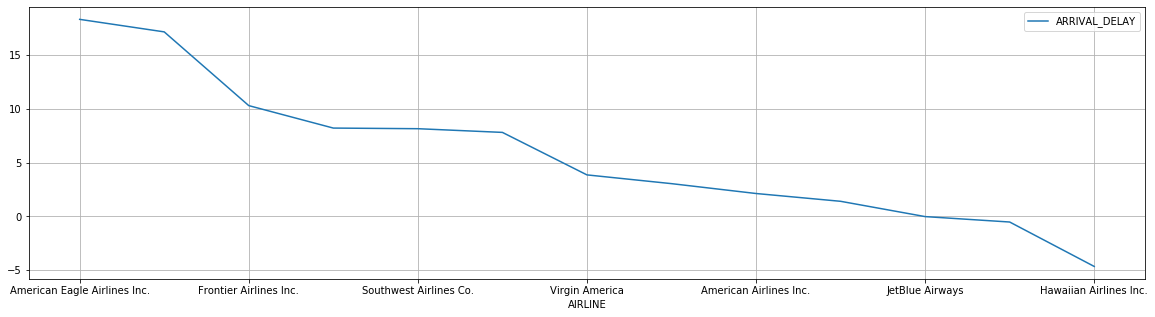

In [32]:
display(airlinemindelay[airlinemindelay['ARRIVAL_DELAY'] == airlinemindelay['ARRIVAL_DELAY'].min()])

airlinemindelay.sort_values(by = 'ARRIVAL_DELAY', ascending = False).plot(figsize=(20, 5), x = 'AIRLINE', grid=True);

Также посмотрим на значение минимальной задержки прилёта только среди авиакомпаний, где среднее значение задержки неотрицательное

In [33]:
display(airlinemindelay[airlinemindelay['ARRIVAL_DELAY'] == airlinemindelay.query('ARRIVAL_DELAY >= 0')['ARRIVAL_DELAY'].min()])

,ARRIVAL_DELAY,IATA_CODE,AIRLINE
3,1.398882,DL,Delta Air Lines Inc.


***Вывод:***

Самой пунктуальной авиакомпаний на прилёт в Los Angeles International Airport оказалась Hawaiian Airlines Inc..
В среднем она прилетает раньше расписания на 4.6 минуты.

Среди авиакомпаний с неотрицательной задержкой прилёта лидирует Delta Air Lines Inc., её задержка вылета составляет в среднем 1.4 минуты.

<a name="airportmintaxi"></a>

## 4. Найдём аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)

Нам будут нужны названия аэропортов и городов из датасета airports:
- `IATA_CODE` - код аэропорта (для объединения с таблицей по данным flights)
- `AIRPORT` - название аэропорта
- `CITY` - город

Данные о прилётах из датасета flights из полей:
- `ORIGIN_AIRPORT` - аэропорт отправления (код)
- `TAXI_OUT` - время руления в аэропорту отправления
- `DESTINATION_AIRPORT` - аэропорт назначения (код)
- `TAXI_IN` - время руления в аэропорту назначения

<a name="taxi"></a>

**Узнаем, сколько времени самолёты проводят на рулении в каждом аэропорту как на вылете, так и при прилёте**

Отфильтруем время руления в аэропортах отправления

In [34]:
origairporttaxi = flights[['ORIGIN_AIRPORT', 'TAXI_OUT']]
origairporttaxi.rename(columns={'ORIGIN_AIRPORT':'AIRPORT', 'TAXI_OUT':'TAXI'}, inplace=True)

origairporttaxi.head()

,AIRPORT,TAXI
0,ANC,21.0
1,LAX,12.0
2,SFO,16.0
3,LAX,15.0
4,SEA,11.0


Теперь оставим время руления в аэропортах назначения

In [35]:
departairporttaxi = flights[['DESTINATION_AIRPORT', 'TAXI_IN']]
departairporttaxi = departairporttaxi.rename(columns={'DESTINATION_AIRPORT':'AIRPORT', 'TAXI_IN':'TAXI'})

departairporttaxi.head()

,AIRPORT,TAXI
0,SEA,4.0
1,PBI,4.0
2,CLT,11.0
3,MIA,8.0
4,ANC,5.0


Объединим полученные данные в одну таблицу

In [36]:
airporttaxi = pd.concat([origairporttaxi, departairporttaxi], ignore_index=True, sort=False)

airporttaxi.head()

,AIRPORT,TAXI
0,ANC,21.0
1,LAX,12.0
2,SFO,16.0
3,LAX,15.0
4,SEA,11.0


<a name="meantaxi"></a>

**Найдём среднее время руления в каждом аэропорту и выберем топ аэропортов с самым большим временем**

Узнаем среднее время руления по каждому аэропорту (код)

In [37]:
airporttaximean = airporttaxi.groupby(['AIRPORT'])['TAXI'].mean().reset_index()

airporttaximean

,AIRPORT,TAXI
0,ABE,8.657387
1,ABI,6.595538
2,ABQ,8.757731
3,ABR,10.611225
4,ABY,7.840252
...,...,...
317,WRG,5.723239
318,WYS,8.293976
319,XNA,9.848584
320,YAK,5.934737


Добавим названия аэропортов и городов в таблицу со временем руления

In [38]:
airporttaximean = airporttaximean.merge(airports[['IATA_CODE', 'AIRPORT', 'CITY']],
                                        left_on = 'AIRPORT', right_on = 'IATA_CODE', how = 'inner')
airporttaximean = airporttaximean.drop(['AIRPORT_x'], axis = 1)
airporttaximean = airporttaximean.rename(columns = {"AIRPORT_y":"AIRPORT"})

airporttaximean.head()

,TAXI,IATA_CODE,AIRPORT,CITY
0,8.657387,ABE,Lehigh Valley International Airport,Allentown
1,6.595538,ABI,Abilene Regional Airport,Abilene
2,8.757731,ABQ,Albuquerque International Sunport,Albuquerque
3,10.611225,ABR,Aberdeen Regional Airport,Aberdeen
4,7.840252,ABY,Southwest Georgia Regional Airport,Albany


Определим топ-5 аэропортов, где самолёты дольше остальных аэропортов проводят время на рулении (от аэропорта до взлёта и от посадки до аэропорта)

In [39]:
top5taxi = airporttaximean.sort_values(by = 'TAXI', ascending = False).head(5)

top5taxi

,TAXI,IATA_CODE,AIRPORT,CITY
182,17.788018,LGA,LaGuardia Airport (Marine Air Terminal),New York
166,17.732032,JFK,John F. Kennedy International Airport (New Yor...,New York
228,16.353151,ORD,Chicago O'Hare International Airport,Chicago
106,14.868676,EWR,Newark Liberty International Airport,Newark
66,14.638993,CLT,Charlotte Douglas International Airport,Charlotte


***Выводы:***

Среднее время руления в районе 15 минут - такое значение у топ-5 самых "долгих для руления" аэропортов.

Видимо, в Нью-Йорке аэропорты построены так, что самолётам приходится выруливать на взлёт и рулить после посадки дольше, чем в других аэропортах - почти 18 минут.

<a name="model"></a>

## 5. Построим модель, которая будет выбирать топ-3 аэропорта прилёта в зависимости от аэропорта вылета 
(вероятность опоздания минимальная - RMSE метрика)

<a name="make_features"></a>

**Функция для генерации фич**

Создадим функцию, которая будет показывать время опоздания за несколько прошедших дней в разрезе дат (год, месяц, день, день недели) - на этих фичах будем обучать модель

In [48]:
def make_features(data, max_lag):
    data['year'] = data['DATE'].dt.year
    data['month'] = data['DATE'].dt.month
    data['day'] = data['DATE'].dt.day
    data['dayofweek'] = data['DATE'].dt.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY'].shift(lag)

<a name="fitmodel"></a>

**Готовим данные с опозданиями в разрезе временных периодов и обучаем модель**

***Дисклеймер:*** 

Для обучения модели предсказанию опоздания прилёта на примере конкретных пар `ORIGIN_AIRPORT` - `DESTINATION_AIRPORT` (аэропорт вылета - аэропорт прилёта) *не хватает данных*, поэтому соберём таблицу с опозданиями прилётов в разрезе по датам в каждый конкретный аэропорт `DESTINATION_AIRPORT`, но без привязки к эропорту вылета.

In [41]:
%%time

flight_sum_delay = flights.groupby(['DATE', 'DESTINATION_AIRPORT'])['ARRIVAL_DELAY'].sum().reset_index()
flight_sum_delay['DATE'] = pd.to_datetime(flight_sum_delay['DATE']) # принудительно присваиваем датам тип datetime

flight_sum_delay.head()

Wall time: 840 ms


,DATE,DESTINATION_AIRPORT,ARRIVAL_DELAY
0,2015-01-01,ABE,-34.0
1,2015-01-01,ABQ,654.0
2,2015-01-01,ABR,-19.0
3,2015-01-01,ABY,-29.0
4,2015-01-01,ACT,182.0


С помощью функции make_features для каждого аэропорта прилета `DESTINATION_AIRPORT` создадим набор значений с временем опоздания за последние 30 дней.

На этих агрегированных данных по опозданиям прилётов на временных рядах обучим модель линейной регрессии и соберём таблицу с показателями метрики RMSE модели для каждого аэропорта прилёта.

Обучающую и валидационную выборку разделим в процентном соотношении 70 к 30.

In [49]:
%%time

finish_airport = []

for dest in flight_sum_delay['DESTINATION_AIRPORT'].unique():
    finish_airport_delay = flight_sum_delay[flight_sum_delay['DESTINATION_AIRPORT']==dest][['DATE','ARRIVAL_DELAY']]
    finish_airport_delay.columns = ['DATE', 'ARRIVAL_DELAY']
    finish_airport_delay = pd.DataFrame(finish_airport_delay)
    
    try:
    
        make_features(finish_airport_delay, 30)  
        finish_airport_delay.dropna(inplace=True) # удалим строки с пустыми значениями
        finish_airport_delay.set_index('DATE', inplace=True) # поместим дату в индекс
        
        # делим данные и обучаем модель
        X_train, X_test, y_train, y_test = train_test_split(finish_airport_delay.drop('ARRIVAL_DELAY', axis=1),
                                                            finish_airport_delay['ARRIVAL_DELAY'], 
                                                            shuffle=False, 
                                                            test_size=0.3, 
                                                            random_state=0)

        model_lr = LinearRegression()
        model_lr.fit(X_train, y_train)

        y_predicted_lr = model_lr.predict(X_test)
        
        # соберём таблицу с данными с реальным средним зачением опоздания и метрикой модели RMSE по каждому аэропорту прилета
        finish_airport.append([dest, y_test.mean(), np.sqrt(mean_squared_error(y_test, y_predicted_lr))])

    except Exception as e:
        print('Error', str(e))
        
        
finish_airport = pd.DataFrame(finish_airport)
finish_airport.columns = ['DESTINATION_AIRPORT', 'MEAN_ARRIVAL_DELAY_IN_PAST', 'RMSE']

Error With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.
Wall time: 15.4 s


In [50]:
# посмотрим, что получилось

finish_airport.head()

,DESTINATION_AIRPORT,MEAN_ARRIVAL_DELAY_IN_PAST,RMSE
0,ABE,25.247525,95.666552
1,ABQ,191.742574,426.031999
2,ABR,-1.960396,43.055769
3,ABY,28.277228,65.398582
4,ACT,-0.690000,82.038169


<a name="top3destairport"></a>

**Топ-3 аэропорта прилёта для каждого аэропорта вылета**

Соберём таблицу топ-3 аэропорта прилёта в зависимости от аэропорта вылета:

1. Для каждого аэропорта вылета `ORIGIN_AIRPORT` собираем таблицу с его аэропортами прилёта (уникальными). 


2. К этим данным добавляем данные с показателями реальных опозданий и показателями RMSE метрики модели для каждого аэропорта прилёта `DESTINATION_AIRPORT`.


3. Для каждого аэропорта вылета определим топ-3 аэропортов прилёта на основании минимального опоздания на ретро-данных и минимального показателя RMSE метрики (где модель максимально точно предсказала опоздание).

In [44]:
%%time

top3_finish_airport = []

for orig in flights['ORIGIN_AIRPORT'].unique():
    start_airport = flights[flights['ORIGIN_AIRPORT']==orig]['DESTINATION_AIRPORT'].unique()
    start_airport = pd.DataFrame(start_airport)
    start_airport['ORIGIN_AIRPORT'] = orig
    start_airport.columns = ['DESTINATION_AIRPORT', 'ORIGIN_AIRPORT']
    
    start_airport = start_airport[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]

    top3 = start_airport.merge(finish_airport, on='DESTINATION_AIRPORT', how='inner')\
                        .sort_values(by=['RMSE', 'MEAN_ARRIVAL_DELAY_IN_PAST'], ascending=[True, True])\
                        .head(3)
    
    top3_finish_airport.append(top3)

flights_top3_finish_airport = pd.concat(top3_finish_airport)
flights_top3_finish_airport.head(5)

Wall time: 3min 3s


,ORIGIN_AIRPORT,DESTINATION_AIRPORT,MEAN_ARRIVAL_DELAY_IN_PAST,RMSE
27,ANC,DLG,-8.733333,13.068571
28,ANC,AKN,-2.600000,14.744428
19,ANC,ADQ,-2.343750,17.824254
67,LAX,SMX,-2.287129,60.623965
72,LAX,RDM,12.356436,80.601430


In [45]:
# проверяем, что ни один аэропорт вылета не потерялся, и данные есть для всех 322 аэропортов

flights_top3_finish_airport['ORIGIN_AIRPORT'].nunique()

322

Добавим названия аэропортов и городов из таблицы airports в полученную таблицу

In [46]:
# добавляем названия и город для аэропортов вылета

flights_top3_finish_airport_full = flights_top3_finish_airport.merge(airports[['IATA_CODE', 'AIRPORT', 'CITY']], 
                                        left_on = 'ORIGIN_AIRPORT', right_on = 'IATA_CODE', how = 'inner')
del flights_top3_finish_airport_full['IATA_CODE']

flights_top3_finish_airport_full = flights_top3_finish_airport_full.rename(columns = {"ORIGIN_AIRPORT":"ORIGIN_AIRPORT_CODE",
                                                                             "AIRPORT":"ORIGIN_AIRPORT",
                                                                             "CITY":"ORIGIN_AIRPORT_CITY"})

# добавляем названия и город для аэропортов прилёта

flights_top3_finish_airport_full = flights_top3_finish_airport_full.merge(airports[['IATA_CODE', 'AIRPORT', 'CITY']], 
                                         left_on = 'DESTINATION_AIRPORT', right_on = 'IATA_CODE', how = 'inner')
del flights_top3_finish_airport_full['IATA_CODE']

flights_top3_finish_airport_full = flights_top3_finish_airport_full.rename(columns = {"DESTINATION_AIRPORT":"DESTINATION_AIRPORT_CODE",
                                                                             "AIRPORT":"DESTINATION_AIRPORT",
                                                                             "CITY":"DESTINATION_AIRPORT_CITY"})

# отсортируем столбцы в удобном порядке

flights_top3_finish_airport_full = flights_top3_finish_airport_full[['ORIGIN_AIRPORT_CODE', 'ORIGIN_AIRPORT', 'ORIGIN_AIRPORT_CITY',
                                                             'DESTINATION_AIRPORT_CODE', 'DESTINATION_AIRPORT', 'DESTINATION_AIRPORT_CITY', 
                                                             'MEAN_ARRIVAL_DELAY_IN_PAST', 'RMSE']]
flights_top3_finish_airport_full.head()

,ORIGIN_AIRPORT_CODE,ORIGIN_AIRPORT,ORIGIN_AIRPORT_CITY,DESTINATION_AIRPORT_CODE,DESTINATION_AIRPORT,DESTINATION_AIRPORT_CITY,MEAN_ARRIVAL_DELAY_IN_PAST,RMSE
0,ANC,Ted Stevens Anchorage International Airport,Anchorage,DLG,Dillingham Airport,Dillingham,-8.733333,13.068571
1,ANC,Ted Stevens Anchorage International Airport,Anchorage,AKN,King Salmon Airport,King Salmon,-2.600000,14.744428
2,ANC,Ted Stevens Anchorage International Airport,Anchorage,ADQ,Kodiak Airport,Kodiak,-2.343750,17.824254
3,LAX,Los Angeles International Airport,Los Angeles,SMX,Santa Maria Public Airport (Capt G. Allan Hanc...,Santa Maria,-2.287129,60.623965
4,SFO,San Francisco International Airport,San Francisco,SMX,Santa Maria Public Airport (Capt G. Allan Hanc...,Santa Maria,-2.287129,60.623965


***Вывод:***

Ориентируясь на минимальное значение RMSE метрики модели, мы получили таблицу, где для каждого аэропорта вылета отобраны 3 аэропорта прилёта с минимальным возможным опозданием (по возрастанию времени опоздания, включая в том числе и прилёт раньше времени).

<a name="conclusion"></a>

## Сформулируем общие выводы

1. Аэропорт с минимальной задержкой вылета

    - В аэропорту Bert Mooney Airport (город Butte, штат Montana) вылеты происходят с минимальной задержкой от расписания среднем 0.11 минут.
    - А в аэропорту Yakutat Airport (город Yakutat, штат Alaska) самолёты вылетают раньше расписания на 6.3 минуты в среднем.
    
    
2. Самая пунктуальная авиакомпания на прилёт в Los Angeles International Airport

    - Самой пунктуальной авиакомпаний на прилёт в Los Angeles International Airport оказалась Hawaiian Airlines Inc., в среднем она прилетает раньше расписания на 4.6 минуты.
    - Среди авиакомпаний с неотрицательной задержкой прилёта лидирует Delta Air Lines Inc., её задержка вылета составляет в среднем 1.4 минуты.


3. Аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)

    - Среднее время руления в районе 15 минут - такое значение у топ-5 самых "долгих для руления" аэропортов.
    - Видимо, в Нью-Йорке аэропорты построены так, что самолётам приходится выруливать на взлёт и рулить после посадки дольше, чем в других аэропортах - почти 18 минут в двух нью-йорских аэропортах.


4. Топ-3 аэропорта прилёта в зависимости от аэропорта вылета (вероятность опоздания минимальная - RMSE метрика)     
    
    Ориентируясь на минимальное значение RMSE метрики модели, получена таблица, где для каждого аэропорта вылета отобраны 3 аэропорта прилёта с минимальным возможным опозданием (по возрастанию времени опоздания, включая в том числе и прилёт раньше времени).